In [2]:
# core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# file download
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi

# final eval
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification
from sklearn.metrics import classification_report

# styles
plt.style.use('dark_background')

# authentication
api = KaggleApi()
api.authenticate()

# Load Data

In [2]:
# download dataset with Kaggle API
api.dataset_download_file('rmisra/news-category-dataset/','News_Category_Dataset_v3.json')

# designate downloaded file as zip, and unzip
zf = ZipFile('News_Category_Dataset_v3.json.zip')
zf.extractall()
zf.close()

# read in data as df
news = pd.read_json('News_Category_Dataset_v3.json', orient='records', lines=True)

# delete downloaded zip and extracted csv - keep your directory clean!
os.remove('News_Category_Dataset_v3.json.zip')
os.remove('News_Category_Dataset_v3.json')

# view
display(news.head())
print(f'\n----\nShape: {news.shape}')

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22



----
Shape: (209527, 6)


# EDA

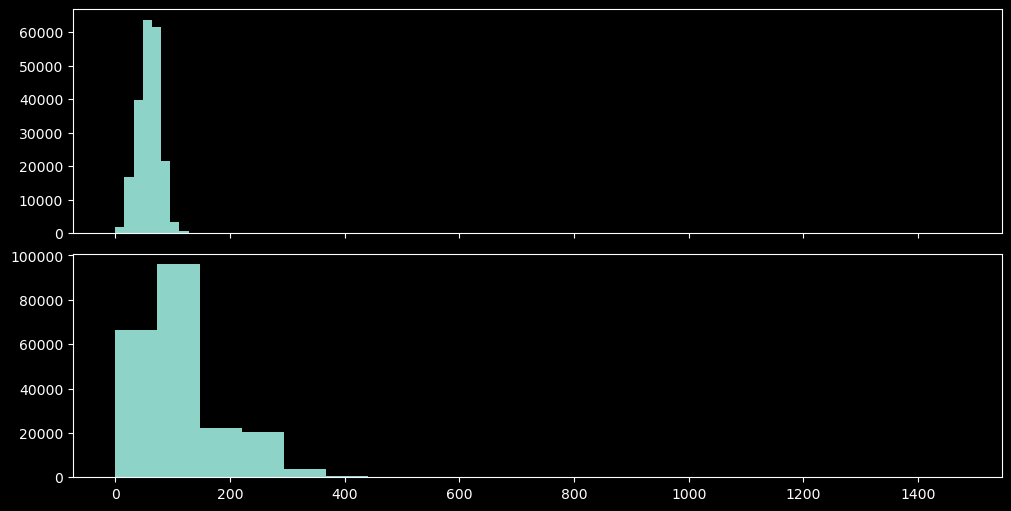

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout='constrained')
ax[0].hist(pd.Series([len(x) for x in news.headline]), bins=20),
ax[1].hist(pd.Series([len(x) for x in news.short_description]), bins=20)
plt.show()

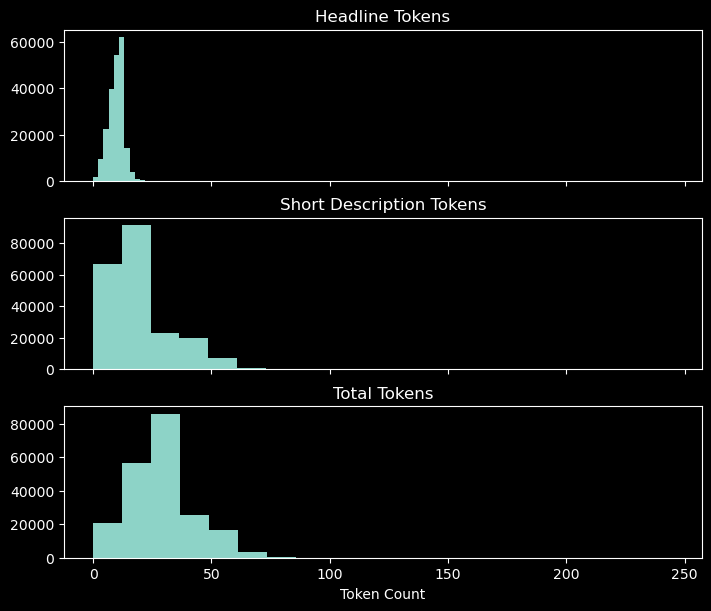

In [4]:
news['headline_tokens'] = news.headline.apply(lambda x: len(x.split()))
news['short_description_tokens'] = news.short_description.apply(lambda x: len(x.split()))
news['total_tokens'] = news.headline_tokens + news.short_description_tokens

fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True, layout='constrained')
ax[0].hist(news.headline_tokens, bins=20)
ax[0].set_title('Headline Tokens')
ax[1].hist(news.short_description_tokens, bins=20)
ax[1].set_title('Short Description Tokens')
ax[2].hist(news.total_tokens, bins=20)
ax[2].set_title('Total Tokens')
ax[2].set_xlabel('Token Count')
plt.show()

In [5]:
news.total_tokens.describe()

count    209527.000000
mean         29.269770
std          13.803927
min           0.000000
25%          20.000000
50%          28.000000
75%          35.000000
max         245.000000
Name: total_tokens, dtype: float64

In [6]:
print(
    f'Number of unique categories: {len(news.category.unique())}',
    f'/nNumber of unique authors: {len(news.authors.unique())}',
    f'/nNumber of unique dates: {len(news.date.unique())}',
)

Number of unique categories: 42 /nNumber of unique authors: 29169 /nNumber of unique dates: 3890


category
POLITICS          0.169916
WELLNESS          0.085645
ENTERTAINMENT     0.082863
TRAVEL            0.047249
STYLE & BEAUTY    0.046839
PARENTING         0.041956
HEALTHY LIVING    0.031948
QUEER VOICES      0.030292
FOOD & DRINK      0.030259
BUSINESS          0.028598
COMEDY            0.025772
SPORTS            0.024231
BLACK VOICES      0.021873
HOME & LIVING     0.020618
PARENTS           0.018876
THE WORLDPOST     0.017487
WEDDINGS          0.017435
WOMEN             0.017048
CRIME             0.017000
IMPACT            0.016628
DIVORCE           0.016351
WORLD NEWS        0.015745
MEDIA             0.014051
WEIRD NEWS        0.013254
GREEN             0.012514
WORLDPOST         0.012309
RELIGION          0.012299
STYLE             0.010758
SCIENCE           0.010528
TECH              0.010042
TASTE             0.010003
MONEY             0.008381
ARTS              0.007202
ENVIRONMENT       0.006892
FIFTY             0.006686
GOOD NEWS         0.006672
U.S. NEWS         0

C:\Users\Keith\AppData\Local\Temp\ipykernel_15668\2086766756.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(news.category.value_counts().index, rotation=70)


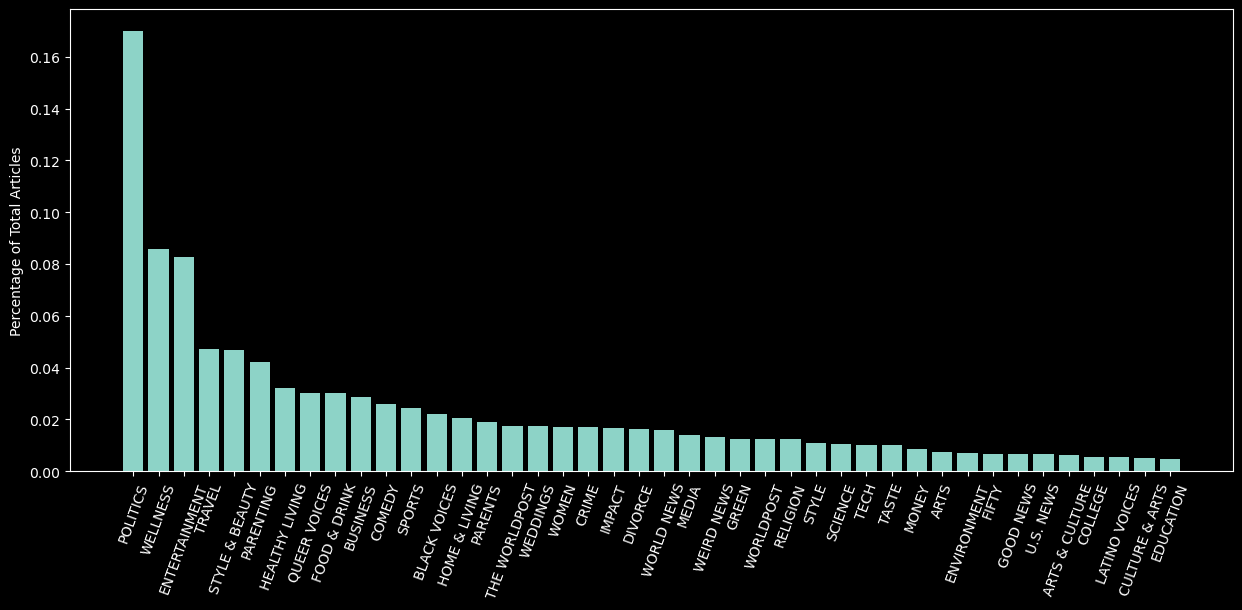

In [7]:
print(news.category.value_counts(normalize=True))

fig, ax = plt.subplots(figsize = (15, 6))
ax.bar(
    news.category.value_counts().index,
    news.category.value_counts().values / news.shape[0]
)
ax.set_xticklabels(news.category.value_counts().index, rotation=70)
ax.set_ylabel('Percentage of Total Articles')
plt.show()

# Preprocessing

In [3]:
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['CONSOLIDATE_LABELS'] = False
config['CONSOLIDATE_OTHER'] = False
config['DATA_AUGMENTATION'] = False
config['TRAIN_SPLIT_PROP'] = 0.8
config['PRETRAINED_LM'] = 'bert-base-uncased'
config['LOGGING'] = True
config['MAX_LENGTH'] = 64

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)

%run scripts/preprocess.py

Loaded 209527 records with 42 categories
Finished Split - Train: 167621, Test: 20953, Valid: 20953
Finished Labels - Train: 167621, Test: 20953, Valid: 20953
Finished TF-IDF - Train: torch.Size([167621, 5000]), Test: torch.Size([20953, 5000]), Valid: torch.Size([20953, 5000])
Finished BERT Data - Train: torch.Size([167621, 64]), Test: torch.Size([20953, 64]), Valid: torch.Size([20953, 64])

Preprocessing Script Complete - Time Elapsed - 1.54 minutes


# Benchmark Training

In [24]:
%run scripts/train_benchmarks.py


--Logistic Regression Results--
Train Accuracy: 64.00%
Train F-1 Score: 61.89%
Validation Accuracy: 57.92%
Validation F-1 Score: 55.21%
Time Elapsed: 7.58 minutes

--XGBoost Results--
Train Accuracy: 65.78%
Train F-1 Score: 64.65%
Validation Accuracy: 55.34%
Validation F-1 Score: 53.25%
Time Elapsed: 8.72 minutes
Total Time: 8.73 minutes


# Baseline BERT Training + Error Analysis

In [31]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=14, 
    output_attentions=False, output_hidden_states=False
)

model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
# Set hyperparameters via config
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['BALANCE_FACTOR'] = 0.5
config['NUM_EPOCHS'] = 20
config['BATCH_SIZE'] = 128
config['LEARNING_RATE'] = 2e-05
config['DROPOUT'] = 0.3
config['LOGGING'] = True
config['PATIENCE'] = 5

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Run training script
%run scripts/train_bert.py

Training Loop Started...
--Epoch: 1 Complete - Time Elapsed - 3.23 minutes 
Train Loss: 1.9562 
Validation Loss: 1.2747
--Epoch: 2 Complete - Time Elapsed - 6.39 minutes 
Train Loss: 1.3078 
Validation Loss: 1.1693
--Epoch: 3 Complete - Time Elapsed - 9.61 minutes 
Train Loss: 1.1251 
Validation Loss: 1.1116
--Epoch: 4 Complete - Time Elapsed - 12.81 minutes 
Train Loss: 1.0118 
Validation Loss: 1.1128
--Epoch: 5 Complete - Time Elapsed - 15.92 minutes 
Train Loss: 0.9098 
Validation Loss: 1.1038
--Epoch: 6 Complete - Time Elapsed - 18.98 minutes 
Train Loss: 0.8320 
Validation Loss: 1.0815
--Epoch: 7 Complete - Time Elapsed - 22.02 minutes 
Train Loss: 0.7622 
Validation Loss: 1.1013
--Epoch: 8 Complete - Time Elapsed - 25.10 minutes 
Train Loss: 0.7050 
Validation Loss: 1.1180
--Epoch: 9 Complete - Time Elapsed - 28.23 minutes 
Train Loss: 0.6503 
Validation Loss: 1.1375
--Epoch: 10 Complete - Time Elapsed - 31.34 minutes 
Train Loss: 0.6063 
Validation Loss: 1.1583
--Early Stopping 

In [2]:
error_file = 'train_results_baseline' ### REQUIRES MANUAL UPDATE ###
summary = pd.read_excel(f'logs/{error_file}.xlsx', sheet_name='summary', index_col=0)
summary

,04.05_14.13
CONSOLIDATE_LABELS,False
CONSOLIDATE_OTHER,False
DATA_AUGMENTATION,False
TRAIN_SPLIT_PROP,0.8
MAX_LENGTH,64
PRETRAINED_LM,bert-base-uncased
BALANCE_FACTOR,0.5
BATCH_SIZE,128
NUM_EPOCHS,20
LEARNING_RATE,0.00002


In [ ]:
valid_class_report = pd.read_excel(f'logs/{error_file}.xlsx', sheet_name='valid_class_report', index_col=0)
valid_class_report = valid_class_report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)
valid_class_report.support = valid_class_report.support.astype(int)
valid_class_report.sort_values(by='f1-score')

,precision,recall,f1-score,support
FIFTY,0.328571,0.400000,0.360784,115
U.S. NEWS,0.576642,0.279152,0.376190,283
GOOD NEWS,0.414286,0.432836,0.423358,134
WOMEN,0.439776,0.451149,0.445390,348
ENVIRONMENT,0.462069,0.475177,0.468531,141
IMPACT,0.482759,0.467967,0.475248,359
TASTE,0.521531,0.441296,0.478070,247
WEIRD NEWS,0.464029,0.503906,0.483146,256
PARENTS,0.501266,0.468085,0.484108,423
GREEN,0.507634,0.468310,0.487179,284


In [ ]:
valid_class_report.loc[valid_class_report['f1-score'] < 0.7].sort_values(by='f1-score')

,precision,recall,f1-score,support
FIFTY,0.328571,0.400000,0.360784,115
U.S. NEWS,0.576642,0.279152,0.376190,283
GOOD NEWS,0.414286,0.432836,0.423358,134
WOMEN,0.439776,0.451149,0.445390,348
ENVIRONMENT,0.462069,0.475177,0.468531,141
IMPACT,0.482759,0.467967,0.475248,359
TASTE,0.521531,0.441296,0.478070,247
WEIRD NEWS,0.464029,0.503906,0.483146,256
PARENTS,0.501266,0.468085,0.484108,423
GREEN,0.507634,0.468310,0.487179,284


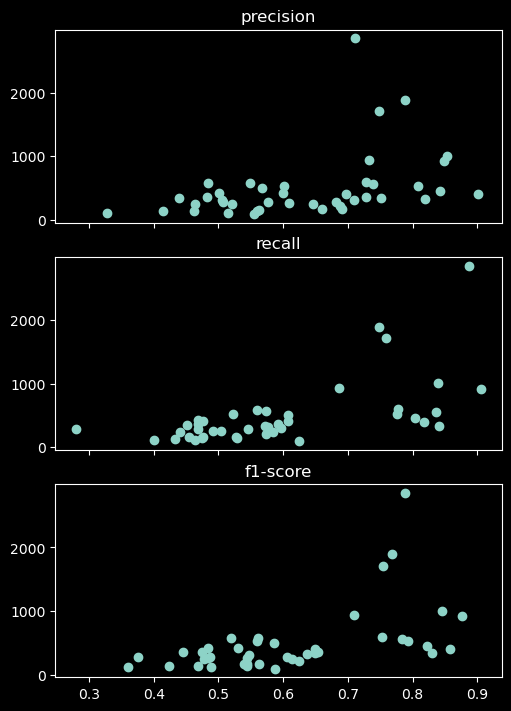

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(5,7), sharey=True, sharex=True, layout = 'constrained')

for ax, metric in zip(axes, ['precision', 'recall', 'f1-score']):
    ax.scatter(valid_class_report[metric], valid_class_report['support'])
    ax.set_title(metric)

plt.show()

# Hyperparameter Tuning

### Data Preprocessing Parameters

In [7]:
# Adjust primary config
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['PREPROCESS_FOR_TUNING'] = True
config['PREPROCESS_ONLY_ONCE'] = False

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Adjust hyperparameter grid
with open('scripts/_hp_grid.json', 'r') as f:
    hp_grid = json.load(f)

# Tuning params
hp_grid['CONSOLIDATE_LABELS'] = [True, False]
hp_grid['CONSOLIDATE_OTHER'] = [True, False]
hp_grid['DATA_AUGMENTATION'] = [
    False,
    {
        'PERCENTAGE': 0.2,
        'BACKTRANSLATION': True,
        'DELETION': True,
        'REPLACEMENT': True
    },
    {
        'PERCENTAGE': 0.4,
        'BACKTRANSLATION': True,
        'DELETION': True,
        'REPLACEMENT': True
    }
]

# Static params
hp_grid['TRAIN_SPLIT_PROP'] = [0.5]
hp_grid['MAX_LENGTH'] = [64]
hp_grid['PRETRAINED_LM'] = ['bert-base-uncased']
hp_grid['BALANCE_FACTOR'] = [0.5]
hp_grid['NUM_EPOCHS'] = [20]
hp_grid['BATCH_SIZE'] = [128]
hp_grid['LEARNING_RATE'] = [2e-05]
hp_grid['DROPOUT'] = [0.3]
hp_grid['PATIENCE'] = [1]
hp_grid['LOGGING'] = [False]

with open('scripts/_hp_grid.json', 'w') as f:
    json.dump(hp_grid, f, indent=4)

# Run hyperparameter tuning
%run scripts/tuning.py


RUN NUMBER 1 OF 12 - TIME ELAPSED - 0.00 minutes

----Config----
CONSOLIDATE_LABELS: True
CONSOLIDATE_OTHER: True
DATA_AUGMENTATION: False
TRAIN_SPLIT_PROP: 0.5
PRETRAINED_LM: bert-base-uncased
LOGGING: False
MAX_LENGTH: 64
BATCH_SIZE: 128
NUM_EPOCHS: 20
LEARNING_RATE: 2e-05
DROPOUT: 0.3
BALANCE_FACTOR: 0.5
PATIENCE: 1
RANDOM_SEED: 42
PREPROCESS_FOR_TUNING: True
PREPROCESS_ONLY_ONCE: False

----Preprocess----
Loaded 209527 records with 42 categories
Consolidated labels to 14 classes
Finished Split - Train: 104763, Test: 52382, Valid: 52382
Finished Labels - Train: 104763, Test: 52382, Valid: 52382
Finished TF-IDF - Train: torch.Size([104763, 5000]), Test: torch.Size([52382, 5000]), Valid: torch.Size([52382, 5000])
Finished BERT Data - Train: torch.Size([104763, 64]), Test: torch.Size([52382, 64]), Valid: torch.Size([52382, 64])

Preprocessing Script Complete - Time Elapsed - 1.44 minutes

----Train----


In [6]:
log_file = 'tuning_results_04.03_inputs' ### REQUIRES MANUAL UPDATE ###
results = pd.read_csv(f'logs/{log_file}.csv', index_col=0).transpose()
results.sort_values('valid_accuracy', ascending=False).head(6).transpose()

,04.04_01.08,04.04_02.40,04.04_00.35,04.04_04.39,04.04_03.44,04.04_01.59
CONSOLIDATE_LABELS,True,True,True,True,True,True
CONSOLIDATE_OTHER,True,True,True,True,True,True
DATA_AUGMENTATION,False,NaN,False,NaN,NaN,NaN
TRAIN_SPLIT_PROP,0.8,0.8,0.5,0.8,0.5,0.5
PRETRAINED_LM,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased
LOGGING,False,False,False,False,False,False
MAX_LENGTH,128,128,128,128,128,128
BATCH_SIZE,32,32,32,32,32,32
NUM_EPOCHS,10,10,10,10,10,10
LEARNING_RATE,2e-05,2e-05,2e-05,2e-05,2e-05,2e-05


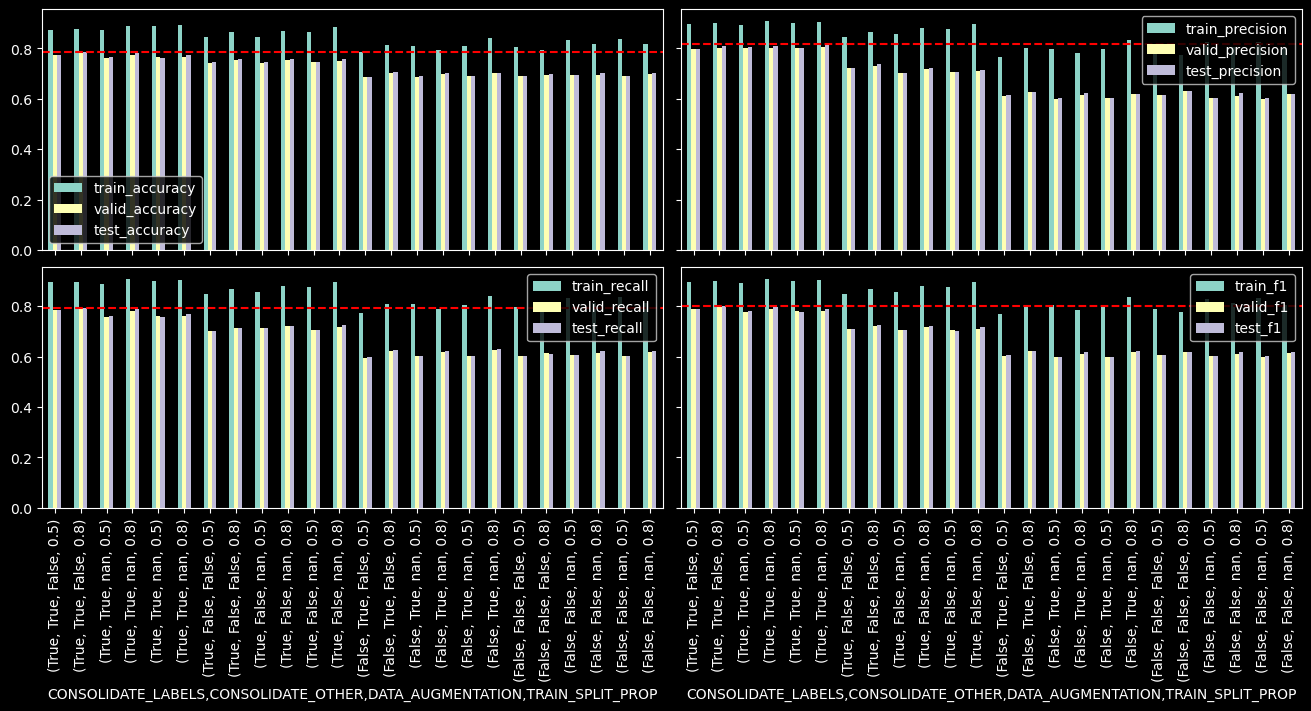

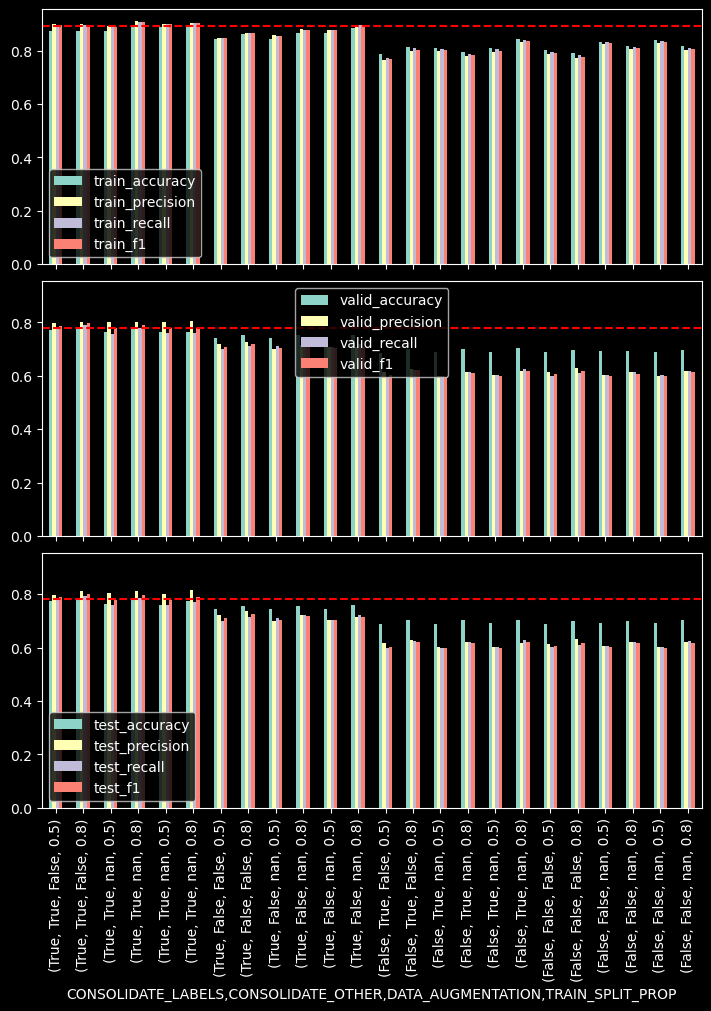

In [7]:
result_cols = [
    'train_accuracy', 'valid_accuracy', 'train_precision', 'valid_precision',
    'train_recall', 'valid_recall', 'train_f1', 'valid_f1'
]
hyperparam_cols = ['CONSOLIDATE_LABELS', 'CONSOLIDATE_OTHER', 'DATA_AUGMENTATION', 'TRAIN_SPLIT_PROP']

plot_df = results.filter(hyperparam_cols + result_cols).set_index(hyperparam_cols)

max_train_acc = plot_df.train_accuracy.astype('float').max()
max_valid_acc = plot_df.valid_accuracy.astype('float').max()

max_train_prec = plot_df.train_precision.astype('float').max()
max_valid_prec = plot_df.valid_precision.astype('float').max()

max_train_rec = plot_df.train_recall.astype('float').max()
max_valid_rec = plot_df.valid_recall.astype('float').max()

max_train_f1 = plot_df.train_f1.astype('float').max()
max_valid_f1 = plot_df.valid_f1.astype('float').max()

fig, axes = plt.subplots(2, 2, figsize=(13,7), sharey=True, sharex=True, layout = 'constrained')

for ax, metric, max in zip(axes.ravel(), ['accuracy', 'precision', 'recall', 'f1'], [max_valid_acc, max_valid_prec, max_valid_rec, max_valid_f1]): 
    plot_df.filter(like=metric, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

fig, axes = plt.subplots(2, 1, figsize=(7,10), sharey=True, sharex=True, layout = 'constrained')

for ax, subset, max in zip(axes, ['train', 'valid'], [max_train_acc, max_valid_acc]): 
    plot_df.filter(like=subset, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

### Other Preprocessing / BERT Hyperparameters

In [2]:
# Adjust primary config
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['PREPROCESS_FOR_TUNING'] = True
config['PREPROCESS_ONLY_ONCE'] = False

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)
    
# Adjust hyperparameter grid
with open('scripts/_hp_grid.json', 'r') as f:
    hp_grid = json.load(f)

# Tuning params
hp_grid['MAX_LENGTH'] = [64, 128]
hp_grid['PRETRAINED_LM'] = ['bert-base-uncased', 'bert-large-uncased']
hp_grid['BALANCE_FACTOR'] = [0.3, 0.5, 0.7]

# Static params
hp_grid['CONSOLIDATE_LABELS'] = [True]
hp_grid['CONSOLIDATE_OTHER'] = [True]
hp_grid['DATA_AUGMENTATION'] = [False]
hp_grid['TRAIN_SPLIT_PROP'] = [0.5]
hp_grid['NUM_EPOCHS'] = [20]
hp_grid['BATCH_SIZE'] = [128]
hp_grid['LEARNING_RATE'] = [2e-05]
hp_grid['DROPOUT'] = [0.3]
hp_grid['PATIENCE'] = [1]
hp_grid['LOGGING'] = [False]

with open('scripts/_hp_grid.json', 'w') as f:
    json.dump(hp_grid, f, indent=4)

# Run hyperparameter tuning
%run scripts/tuning.py


RUN NUMBER 1 OF 12 - TIME ELAPSED - 0.00 minutes

----Config----
CONSOLIDATE_LABELS: True
CONSOLIDATE_OTHER: True
DATA_AUGMENTATION: False
TRAIN_SPLIT_PROP: 0.5
PRETRAINED_LM: bert-base-uncased
LOGGING: False
MAX_LENGTH: 64
BATCH_SIZE: 128
NUM_EPOCHS: 20
LEARNING_RATE: 2e-05
DROPOUT: 0.3
BALANCE_FACTOR: 0.3
PATIENCE: 1
PREPROCESS_FOR_TUNING: True
PREPROCESS_ONLY_ONCE: False

----Preprocess----
Loaded 209527 records with 42 categories
Consolidated labels to 14 classes
Finished Split - Train: 104763, Test: 52382, Valid: 52382
Finished Labels - Train: 104763, Test: 52382, Valid: 52382
Finished TF-IDF - Train: torch.Size([104763, 5000]), Test: torch.Size([52382, 5000]), Valid: torch.Size([52382, 5000])
Finished BERT Data - Train: torch.Size([104763, 64]), Test: torch.Size([52382, 64]), Valid: torch.Size([52382, 64])

Preprocessing Script Complete - Time Elapsed - 1.45 minutes

----Train----
Training Loop Started...
--Epoch: 1 Complete - Time Elapsed - 2.26 minutes 
Train Loss: 1.0989 
Val

In [3]:
log_file = 'tuning_results_bert_other' ### REQUIRES MANUAL UPDATE ###
results = pd.read_csv(f'logs/{log_file}.csv', index_col=0).transpose()
results.sort_values('valid_accuracy', ascending=False).head(6).transpose()

,04.07_19.21,04.07_18.53,04.07_17.18,04.07_19.50,04.07_17.58,04.07_17.43
CONSOLIDATE_LABELS,True,True,True,True,True,True
CONSOLIDATE_OTHER,True,True,True,True,True,True
DATA_AUGMENTATION,False,False,False,False,False,False
TRAIN_SPLIT_PROP,0.5,0.5,0.5,0.5,0.5,0.5
PRETRAINED_LM,bert-large-uncased,bert-large-uncased,bert-base-uncased,bert-large-uncased,bert-base-uncased,bert-base-uncased
LOGGING,False,False,False,False,False,False
MAX_LENGTH,64,64,64,64,128,64
BATCH_SIZE,128,128,128,128,128,128
NUM_EPOCHS,20,20,20,20,20,20
LEARNING_RATE,2e-05,2e-05,2e-05,2e-05,2e-05,2e-05


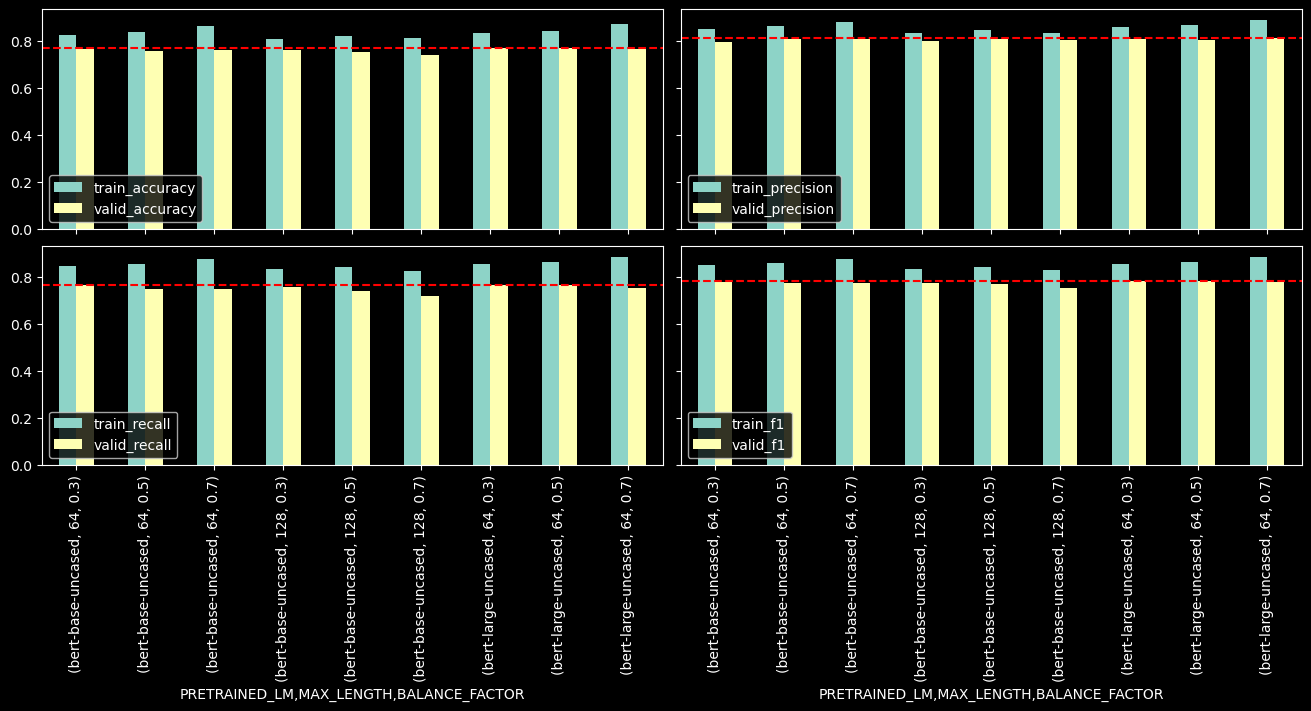

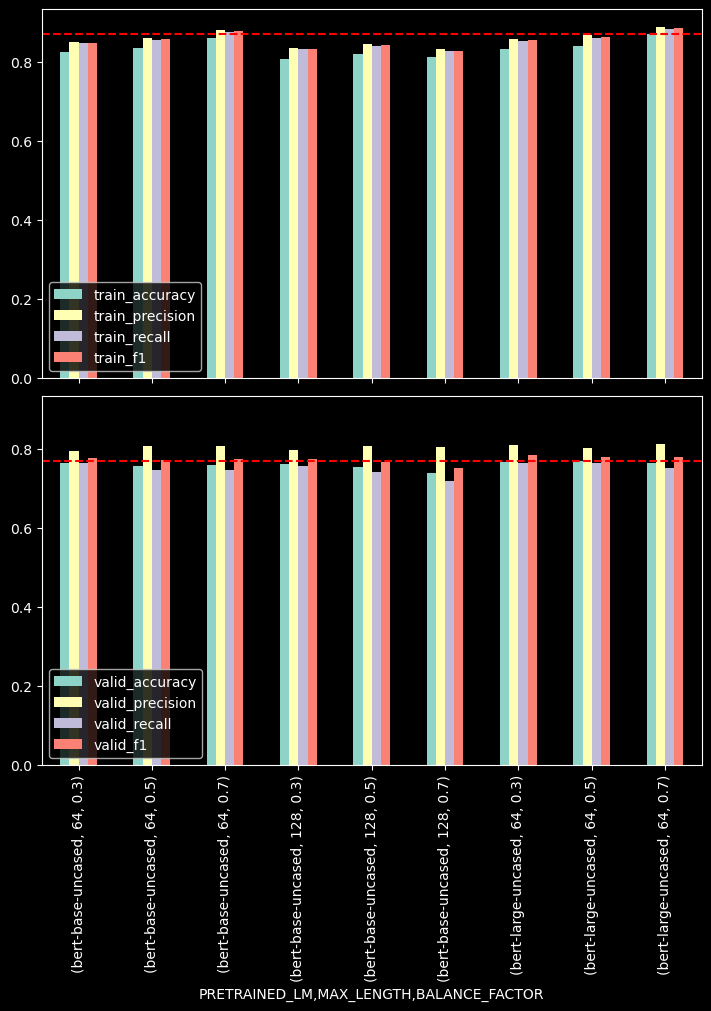

In [4]:
result_cols = [
    'train_accuracy', 'valid_accuracy', 'train_precision', 'valid_precision',
    'train_recall', 'valid_recall', 'train_f1', 'valid_f1'
]
hyperparam_cols = ['PRETRAINED_LM', 'MAX_LENGTH', 'BALANCE_FACTOR']

plot_df = results.filter(hyperparam_cols + result_cols).set_index(hyperparam_cols)

max_train_acc = plot_df.train_accuracy.astype('float').max()
max_valid_acc = plot_df.valid_accuracy.astype('float').max()

max_train_prec = plot_df.train_precision.astype('float').max()
max_valid_prec = plot_df.valid_precision.astype('float').max()

max_train_rec = plot_df.train_recall.astype('float').max()
max_valid_rec = plot_df.valid_recall.astype('float').max()

max_train_f1 = plot_df.train_f1.astype('float').max()
max_valid_f1 = plot_df.valid_f1.astype('float').max()

fig, axes = plt.subplots(2, 2, figsize=(13,7), sharey=True, sharex=True, layout = 'constrained')

for ax, metric, max in zip(axes.ravel(), ['accuracy', 'precision', 'recall', 'f1'], [max_valid_acc, max_valid_prec, max_valid_rec, max_valid_f1]): 
    plot_df.filter(like=metric, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

fig, axes = plt.subplots(2, 1, figsize=(7,10), sharey=True, sharex=True, layout = 'constrained')

for ax, subset, max in zip(axes, ['train', 'valid'], [max_train_acc, max_valid_acc]): 
    plot_df.filter(like=subset, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

### Training Hyperparameters

In [5]:
# Primary config
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['PREPROCESS_FOR_TUNING'] = True
config['PREPROCESS_ONLY_ONCE'] = True

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)
    
# Hyperparameter grid
with open('scripts/_hp_grid.json', 'r') as f:
    hp_grid = json.load(f)

# Tuning params
hp_grid['NUM_EPOCHS'] = [20] # Mostly obviated by early stopping
hp_grid['BATCH_SIZE'] = [64, 128, 256]
hp_grid['LEARNING_RATE'] = [1e-05, 3e-05, 5e-05]
hp_grid['DROPOUT'] = [0.1, 0.3, 0.5]

# Static params
hp_grid['CONSOLIDATE_LABELS'] = [True]
hp_grid['CONSOLIDATE_OTHER'] = [True]
hp_grid['DATA_AUGMENTATION'] = [False]
hp_grid['TRAIN_SPLIT_PROP'] = [0.5]
hp_grid['MAX_LENGTH'] = [64]
hp_grid['PRETRAINED_LM'] = ['bert-base-uncased']
hp_grid['BALANCE_FACTOR'] = [0.3]
hp_grid['PATIENCE'] = [2]
hp_grid['LOGGING'] = [False]

with open('scripts/_hp_grid.json', 'w') as f:
    json.dump(hp_grid, f, indent=4)

# Run hyperparameter tuning
%run scripts/tuning.py


RUN NUMBER 1 OF 27 - TIME ELAPSED - 0.00 minutes

----Config----
CONSOLIDATE_LABELS: True
CONSOLIDATE_OTHER: True
DATA_AUGMENTATION: False
TRAIN_SPLIT_PROP: 0.5
PRETRAINED_LM: bert-base-uncased
LOGGING: False
MAX_LENGTH: 64
BATCH_SIZE: 64
NUM_EPOCHS: 20
LEARNING_RATE: 1e-05
DROPOUT: 0.1
BALANCE_FACTOR: 0.3
PATIENCE: 2
PREPROCESS_FOR_TUNING: True
PREPROCESS_ONLY_ONCE: True

----Preprocess----
Loaded 209527 records with 42 categories
Consolidated labels to 14 classes
Finished Split - Train: 104763, Test: 52382, Valid: 52382
Finished Labels - Train: 104763, Test: 52382, Valid: 52382
Finished TF-IDF - Train: torch.Size([104763, 5000]), Test: torch.Size([52382, 5000]), Valid: torch.Size([52382, 5000])
Finished BERT Data - Train: torch.Size([104763, 64]), Test: torch.Size([52382, 64]), Valid: torch.Size([52382, 64])

Preprocessing Script Complete - Time Elapsed - 1.45 minutes

----Train----
Training Loop Started...
--Epoch: 1 Complete - Time Elapsed - 2.54 minutes 
Train Loss: 1.0164 
Valid

In [6]:
log_file = 'tuning_results_training_hps' ### REQUIRES MANUAL UPDATE ###
results = pd.read_csv(f'logs/{log_file}.csv', index_col=0).transpose()
results.sort_values('valid_accuracy', ascending=False).head(6).transpose()

,04.17_15.33,04.17_11.23,04.17_09.00,04.17_12.20,04.17_14.58,04.17_10.06
CONSOLIDATE_LABELS,True,True,True,True,True,True
CONSOLIDATE_OTHER,True,True,True,True,True,True
DATA_AUGMENTATION,False,False,False,False,False,False
TRAIN_SPLIT_PROP,0.5,0.5,0.5,0.5,0.5,0.5
PRETRAINED_LM,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased,bert-base-uncased
LOGGING,False,False,False,False,False,False
MAX_LENGTH,64,64,64,64,64,64
BATCH_SIZE,256,128,64,128,256,64
NUM_EPOCHS,20,20,20,20,20,20
LEARNING_RATE,5e-05,1e-05,1e-05,3e-05,3e-05,3e-05


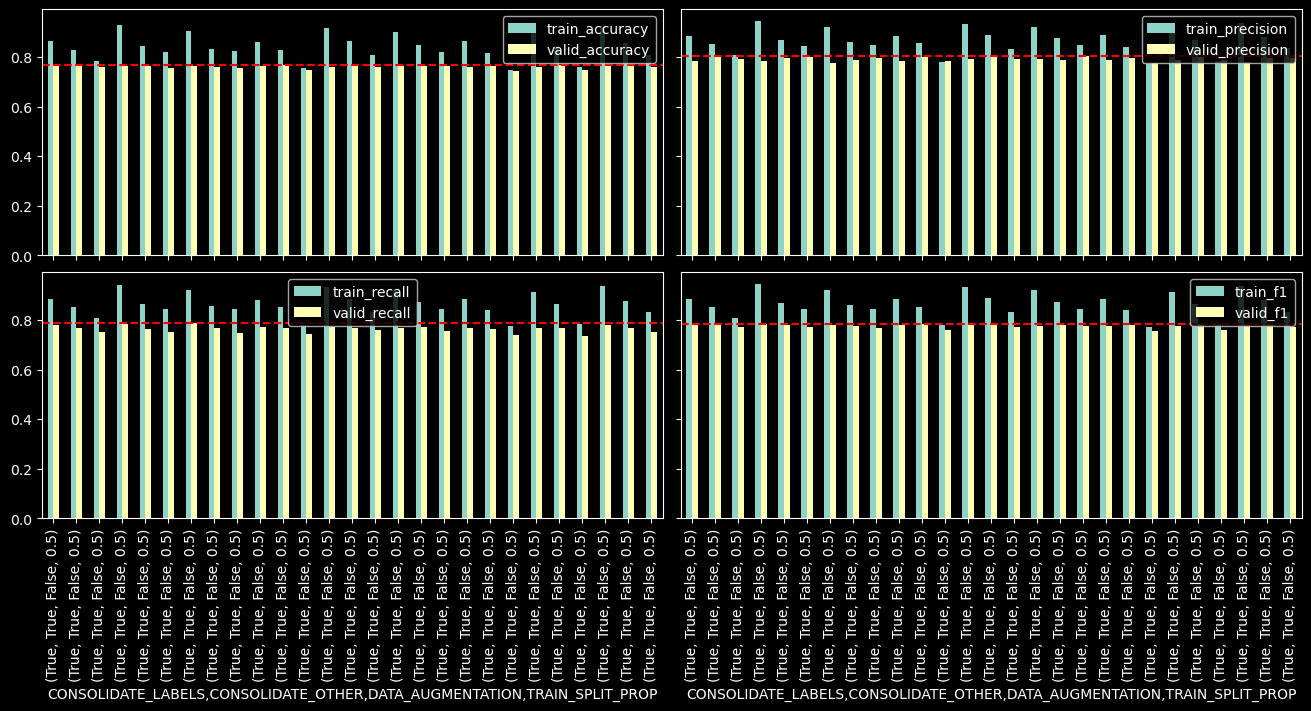

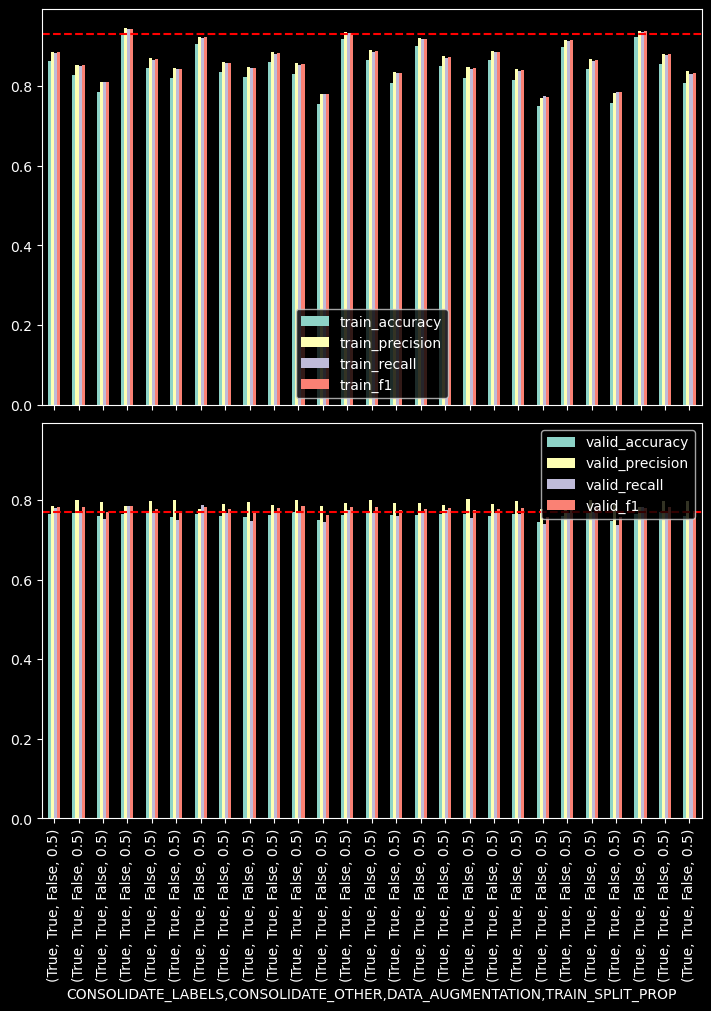

In [7]:
result_cols = [
    'train_accuracy', 'valid_accuracy', 'train_precision', 'valid_precision',
    'train_recall', 'valid_recall', 'train_f1', 'valid_f1'
]
hyperparam_cols = ['CONSOLIDATE_LABELS', 'CONSOLIDATE_OTHER', 'DATA_AUGMENTATION', 'TRAIN_SPLIT_PROP']

plot_df = results.filter(hyperparam_cols + result_cols).set_index(hyperparam_cols)

max_train_acc = plot_df.train_accuracy.astype('float').max()
max_valid_acc = plot_df.valid_accuracy.astype('float').max()

max_train_prec = plot_df.train_precision.astype('float').max()
max_valid_prec = plot_df.valid_precision.astype('float').max()

max_train_rec = plot_df.train_recall.astype('float').max()
max_valid_rec = plot_df.valid_recall.astype('float').max()

max_train_f1 = plot_df.train_f1.astype('float').max()
max_valid_f1 = plot_df.valid_f1.astype('float').max()

fig, axes = plt.subplots(2, 2, figsize=(13,7), sharey=True, sharex=True, layout = 'constrained')

for ax, metric, max in zip(axes.ravel(), ['accuracy', 'precision', 'recall', 'f1'], [max_valid_acc, max_valid_prec, max_valid_rec, max_valid_f1]): 
    plot_df.filter(like=metric, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

fig, axes = plt.subplots(2, 1, figsize=(7,10), sharey=True, sharex=True, layout = 'constrained')

for ax, subset, max in zip(axes, ['train', 'valid'], [max_train_acc, max_valid_acc]): 
    plot_df.filter(like=subset, axis=1).astype('float').plot(kind='bar', ax=ax)
    ax.axhline(y=max, color='r', linestyle='--')

plt.show()

# Final Training and Evaluation

In [2]:
# Set hyperparameters via config
with open('scripts/_config.json', 'r') as f:
    config = json.load(f)

config['CONSOLIDATE_LABELS'] = True
config['CONSOLIDATE_OTHER'] = True
config['DATA_AUGMENTATION'] = False
config['TRAIN_SPLIT_PROP'] = 0.8
config['MAX_LENGTH'] = 64
config['PRETRAINED_LM'] = 'bert-base-uncased'
config['BALANCE_FACTOR'] = 0.3
config['NUM_EPOCHS'] = 20
config['BATCH_SIZE'] = 256
config['LEARNING_RATE'] = 3e-05
config['DROPOUT'] = 0.3
config['PATIENCE'] = 5
config['LOGGING'] = True

with open('scripts/_config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Run preprocessing script
%run scripts/preprocess.py

# Run training script
%run scripts/train_bert.py

Loaded 209527 records with 42 categories
Consolidated labels to 14 classes
Finished Split - Train: 167621, Test: 20953, Valid: 20953
Finished Labels - Train: 167621, Test: 20953, Valid: 20953
Finished TF-IDF - Train: torch.Size([167621, 5000]), Test: torch.Size([20953, 5000]), Valid: torch.Size([20953, 5000])
Finished BERT Data - Train: torch.Size([167621, 64]), Test: torch.Size([20953, 64]), Valid: torch.Size([20953, 64])

Preprocessing Script Complete - Time Elapsed - 1.51 minutes
Training Loop Started...
--Epoch: 1 Complete - Time Elapsed - 3.17 minutes 
Train Loss: 1.0014 
Validation Loss: 0.7789
--Epoch: 2 Complete - Time Elapsed - 6.27 minutes 
Train Loss: 0.6843 
Validation Loss: 0.7141
--Epoch: 3 Complete - Time Elapsed - 9.34 minutes 
Train Loss: 0.5998 
Validation Loss: 0.6946
--Epoch: 4 Complete - Time Elapsed - 12.42 minutes 
Train Loss: 0.5382 
Validation Loss: 0.6909
--Epoch: 5 Complete - Time Elapsed - 15.49 minutes 
Train Loss: 0.4901 
Validation Loss: 0.6898
--Epoch: 6

In [12]:
error_file = 'train_results_final_valid' ### REQUIRES MANUAL UPDATE ###
summary = pd.read_excel(f'logs/{error_file}.xlsx', sheet_name='summary', index_col=0)
summary

,04.17_19.37
CONSOLIDATE_LABELS,True
CONSOLIDATE_OTHER,True
DATA_AUGMENTATION,False
TRAIN_SPLIT_PROP,0.8
PRETRAINED_LM,bert-base-uncased
LOGGING,True
MAX_LENGTH,64
BATCH_SIZE,256
NUM_EPOCHS,20
LEARNING_RATE,0.00003


#### Evaluation on Test Data

In [6]:
# Load test data
input_ids_test = torch.load('data/test_input_ids.pt')
att_masks_test = torch.load('data/test_att_masks.pt')
y_test = torch.load('data/y_test.pt')

test_dataset = TensorDataset(input_ids_test, att_masks_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256) #, sampler=SequentialSampler(test_dataset))

with open('data/code_labels_dict.json', 'r') as f:
    code_labels_dict = json.load(f)
label_names = code_labels_dict.values()

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load('models/bert_model_final.pt')

output_size = len(code_labels_dict.keys())
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=output_size, 
    output_attentions=False, output_hidden_states=False
)
model.load_state_dict(state_dict)
model = model.to(device)

# Predict on Test Subset
model.eval()
test_pred = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
test_pred = np.concatenate(test_pred)

# Classification Reports 
class_report = classification_report(test_pred, y_test, output_dict=True, target_names=label_names, zero_division=0)
class_report['accuracy'] = {
    'precision': '--',
    'recall': class_report['accuracy'],
    'f1-score': '--',
    'support': 0
}

pd.DataFrame(class_report).T

,precision,recall,f1-score,support
Diversity,0.662521,0.700263,0.680869,1141.0
Divorce,0.830409,0.809117,0.819625,351.0
"Entertainment, Art and Media",0.777928,0.77453,0.776225,2976.0
Food & Drink,0.883886,0.826135,0.854035,903.0
General News,0.789377,0.661043,0.719533,1304.0
Home & Living,0.81713,0.811494,0.814302,435.0
OTHER,0.6592,0.741579,0.697967,3889.0
Parenting,0.811617,0.740157,0.774242,1397.0
Politics,0.804213,0.843051,0.823174,3396.0
Sports,0.854331,0.731872,0.788374,593.0
